In [1]:
import requests
import os
from dotenv import load_dotenv
from array import array
from PIL import Image
import sys
import time
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
import pandas as pd
import regex as re
import numpy as np
import io
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from pyzbar.pyzbar import decode


In [2]:
load_dotenv()

True

In [3]:
url = "https://invoiceocrp3.azurewebsites.net/invoices"

headers = {
    "accept": "application/json"
}

In [4]:
data = []

In [5]:
response = requests.get(url, headers=headers)

In [6]:
response

<Response [200]>

In [7]:
data = response.json()
data = data.get('invoices')

In [8]:
lastDate = data[-1]['dt']
flag = False
while not flag : 
    urldata  = f"https://invoiceocrp3.azurewebsites.net/invoices?start_date={lastDate}"
    responseData = requests.get(urldata, headers=headers)
    if responseData.status_code == 200:
            adddata = responseData.json()
            adddata = adddata.get('invoices')
            if len(adddata) == 0:
                flag = True
            else:
                data.extend(adddata)
                lastDate = data[-1]['dt']
                print(lastDate,data[-1])
    else :
        print(f"Erreur: {response.status_code} - {response.reason}") 
        flag = True

2020-10-18 05:00:00 {'no': 'FAC_2020_0823-2487', 'dt': '2020-10-18 05:00:00'}
2021-07-24 00:09:00 {'no': 'FAC_2021_0641-519400', 'dt': '2021-07-24 00:09:00'}
2022-05-26 23:53:00 {'no': 'FAC_2022_0474-6057400', 'dt': '2022-05-26 23:53:00'}
2023-03-28 16:10:00 {'no': 'FAC_2023_0295-359724', 'dt': '2023-03-28 16:10:00'}
2024-02-08 06:03:00 {'no': 'FAC_2024_0122-4602818', 'dt': '2024-02-08 06:03:00'}
2024-04-06 01:16:00 {'no': 'FAC_2024_0331-524891', 'dt': '2024-04-06 01:16:00'}


In [10]:
data

[{'no': 'FAC_2019_0002-521208', 'dt': '2019-01-01 03:29:00'},
 {'no': 'FAC_2019_0001-112650', 'dt': '2019-01-01 08:21:00'},
 {'no': 'FAC_2019_0003-4174848', 'dt': '2019-01-02 01:05:00'},
 {'no': 'FAC_2019_0004-46050', 'dt': '2019-01-02 07:27:00'},
 {'no': 'FAC_2019_0006-6410304', 'dt': '2019-01-03 14:19:00'},
 {'no': 'FAC_2019_0005-1869518', 'dt': '2019-01-03 22:10:00'},
 {'no': 'FAC_2019_0007-2747871', 'dt': '2019-01-04 00:13:00'},
 {'no': 'FAC_2019_0009-2407968', 'dt': '2019-01-04 09:29:00'},
 {'no': 'FAC_2019_0008-2031855', 'dt': '2019-01-04 23:49:00'},
 {'no': 'FAC_2019_0011-585056', 'dt': '2019-01-05 03:18:00'},
 {'no': 'FAC_2019_0010-5403720', 'dt': '2019-01-05 03:29:00'},
 {'no': 'FAC_2019_0013-191970', 'dt': '2019-01-05 15:40:00'},
 {'no': 'FAC_2019_0012-2068045', 'dt': '2019-01-05 20:36:00'},
 {'no': 'FAC_2019_0017-223244', 'dt': '2019-01-06 01:33:00'},
 {'no': 'FAC_2019_0014-6176196', 'dt': '2019-01-06 02:41:00'},
 {'no': 'FAC_2019_0016-3750525', 'dt': '2019-01-06 19:42:00'},

In [9]:
print(data[-1]['no'])
print(len(data))

FAC_2024_0331-524891
6209


In [10]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]

computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [13]:
dataset = data[:5]

In [16]:
# Fonction pour télécharger une image à partir d'une URL
def download_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image

# Fonction pour lire les codes-barres à partir d'une image
def read_barcodes(image):
    merged_text =''
    decoded_objects = decode(image)
    for obj in decoded_objects:
        merged_text += obj.data.decode("utf-8") + ' '

    return merged_text

In [89]:
def get_qr_data(url):
    # URL de l'image en ligne
    image_url = url

    # Télécharger l'image à partir de l'URL
    image = download_image(image_url)



    # Lire les codes-barres à partir de l'image téléchargée
    rep = read_barcodes(image)

    qr_dict = {}

    # Utilisation d'une expression régulière qui considère les sauts de ligne
    pattern = r'(\w+):([^\n]+)'
    matches = re.findall(pattern, rep)

    # Remplissage du dictionnaire avec les correspondances trouvées
    for key, value in matches:
        qr_dict[key.strip()] = value.strip()  # .strip() retire les espaces excédentaires
        
    #separated_values = [{qr_key: qr_value} for qr_key, qr_value in qr_dict.items() if qr_key in ['CUST', 'CAT']]

    return qr_dict


In [149]:
facture = {}
for row in range(len(dataset)) :
    '''
    OCR: Read File using the Read API, extract text - remote
    This example will extract text in an image, then print results, line by line.
    This API call can also extract handwriting style text (not shown).
    '''
    # Get an image with text
    read_image_url = f"https://invoiceocrp3.azurewebsites.net/invoices/{dataset[row]['no']}"

    # Call API with URL and raw response (allows you to get the operation location)
    read_response = computervision_client.read(read_image_url,  raw=True)

    # Get the operation location (URL with an ID at the end) from the response
    read_operation_location = read_response.headers["Operation-Location"]
    # Grab the ID from the URL
    operation_id = read_operation_location.split("/")[-1]
    
    # Call the "GET" API and wait for it to retrieve the results 
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    facture[dataset[row]['no']] = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
    # Itérez à travers chaque objet de ligne
            for ligne_objet in text_result.lines:
            # Créez un dictionnaire pour stocker les données de cette ligne
                    donnees_ligne = {
                        "text": ligne_objet.text,
                        #"bounding_box": ligne_objet.bounding_box,
                        # Ajoutez plus d'attributs selon vos besoins
                    }
                    
                    # Ajoutez les données de cette ligne à la liste correspondante dans le dictionnaire principal
                    facture[dataset[row]['no']].append(donnees_ligne)

    """qr_data = get_qr_data(read_image_url)
    facture[dataset[row]['no']].extend(qr_data)""" # .strip() retire les espaces excédentaires"""

KeyboardInterrupt: 

In [ ]:
FAC_2021_0890-305660

In [44]:
facture = {}

'''
OCR: Read File using the Read API, extract text - remote
This example will extract text in an image, then print results, line by line.
This API call can also extract handwriting style text (not shown).
'''
# Get an image with text
read_image_url = f"https://invoiceocrp3.azurewebsites.net/invoices/FAC_2019_0002-521208"

    # Call API with URL and raw response (allows you to get the operation location)
read_response = computervision_client.read(read_image_url,  raw=True)

    # Get the operation location (URL with an ID at the end) from the response
read_operation_location = read_response.headers["Operation-Location"]
    # Grab the ID from the URL
operation_id = read_operation_location.split("/")[-1]
    
    # Call the "GET" API and wait for it to retrieve the results 
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

facture['FAC_2021_0890'] = []
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
# Itérez à travers chaque objet de ligne
        for ligne_objet in text_result.lines:
            # Créez un dictionnaire pour stocker les données de cette ligne
                donnees_ligne = {
                    "text": ligne_objet.text,
                        #"bounding_box": ligne_objet.bounding_box,
                        # Ajoutez plus d'attributs selon vos besoins
                    }
                    
                    # Ajoutez les données de cette ligne à la liste correspondante dans le dictionnaire principal
                facture['FAC_2021_0890'].append(donnees_ligne)

    """qr_data = get_qr_data(read_image_url)
    facture[dataset[row]['no']].extend(qr_data)""" # .strip() retire les espaces excédentaires"""

In [45]:
facture

{'FAC_2021_0890': [{'text': 'INVOICE FAC_2019_0002'},
  {'text': 'Issue date 2019-01-01 03:29:00'},
  {'text': 'Bill to Sébastien Jean-Vasseur'},
  {'text': 'Brilllling'},
  {'text': 'Address 19246 Flowers Lake Suite 939'},
  {'text': 'New Audreychester, NM 10500'},
  {'text': 'Esse reiciendis facere aperiam.'},
  {'text': '3 x'},
  {'text': ': 56.80 Euro'},
  {'text': 'Voluptatum delectus dolore enim.'},
  {'text': '6 x'},
  {'text': '13.44 Euro'},
  {'text': 'Autem rem cum architecto.'},
  {'text': '7 x'},
  {'text': '15.98 Euro'},
  {'text': 'Rien chaise seconde ciel.'},
  {'text': '1 x 65.23 Euro'},
  {'text': 'TOTAL'},
  {'text': '428.13 Euro'}]}

In [46]:


brut_format = ''
for item in facture['FAC_2021_0890']:

    if None :
        pass
    else:
        brut_format += str(item.get('text')) + "\n"

print(brut_format)


INVOICE FAC_2019_0002
Issue date 2019-01-01 03:29:00
Bill to Sébastien Jean-Vasseur
Brilllling
Address 19246 Flowers Lake Suite 939
New Audreychester, NM 10500
Esse reiciendis facere aperiam.
3 x
: 56.80 Euro
Voluptatum delectus dolore enim.
6 x
13.44 Euro
Autem rem cum architecto.
7 x
15.98 Euro
Rien chaise seconde ciel.
1 x 65.23 Euro
TOTAL
428.13 Euro



In [47]:
class Product:
    def __init__(self, name_product, quantity, price):
        self.name_product = name_product
        self.quantity     = quantity
        self.price        = price

class Invoice:
    def __init__(self, invoice_ref, invoice_date,products, total_products):
        self.invoice_ref    = invoice_ref
        self.invoice_date   = invoice_date
        self.total_products = total_products

class Client:
    def __init__(self,client_id,client_cat,client_address,client_name):
        self.client_id  = client_id
        self.client_address = client_address
        self.client_name    = client_name
        self.client_cat = client_cat

In [48]:
result = ''
regex_total             = r'total\s*(.*?\b(?:euro|$))'
regex_invoice           = r"fac_\d{4}_\d{4}"
regex_address           = r"address\s.*\n.*"
regex_date              = r"date.*?(\d+)-(\d+)-(\d+).(\d+).(\d+).(\d+)"
#regex_products_price    = r"(\d+\.\d+)\s*euro|total\s*(\d+\.\d+)\s*Euro"
#regex_products_name     = r"([^\d\n]+\.)\n"

result = re.sub(regex_total, '', brut_format.lower())
print(result)
print("***********************************")
result = re.sub(regex_invoice, '', result)
print(result)
print("***********************************")
result = re.sub(regex_date, '', result)
print(result)
print("***********************************")
result = re.sub(regex_address, '', result)
#result = re.sub(regex_products_price, '', result)
#result = re.sub(regex_products_name, '', result)
print(result)

invoice fac_2019_0002
issue date 2019-01-01 03:29:00
bill to sébastien jean-vasseur
brilllling
address 19246 flowers lake suite 939
new audreychester, nm 10500
esse reiciendis facere aperiam.
3 x
: 56.80 euro
voluptatum delectus dolore enim.
6 x
13.44 euro
autem rem cum architecto.
7 x
15.98 euro
rien chaise seconde ciel.
1 x 65.23 euro


***********************************
invoice 
issue date 2019-01-01 03:29:00
bill to sébastien jean-vasseur
brilllling
address 19246 flowers lake suite 939
new audreychester, nm 10500
esse reiciendis facere aperiam.
3 x
: 56.80 euro
voluptatum delectus dolore enim.
6 x
13.44 euro
autem rem cum architecto.
7 x
15.98 euro
rien chaise seconde ciel.
1 x 65.23 euro


***********************************
invoice 
issue 
bill to sébastien jean-vasseur
brilllling
address 19246 flowers lake suite 939
new audreychester, nm 10500
esse reiciendis facere aperiam.
3 x
: 56.80 euro
voluptatum delectus dolore enim.
6 x
13.44 euro
autem rem cum architecto.
7 x
15.98 eur

In [147]:


regex_products_name             = r"([^\d\n]+\.)\n"
regex_products_quantity         = r"(?:\b(\d+)?\s*x?\s*)?(.*?\b(?:Euro|$))|TOTAL\s*(.*?\b(?:Euro|$))"
regex_products_price            = r"(\d+\.\d+)\s*Euro|TOTAL\s*(\d+\.\d+)\s*Euro"


match_products_name             = re.findall(regex_products_name, brut_format.lower(),re.IGNORECASE)
match_products_quantity         = re.findall(regex_products_quantity, brut_format.lower(),re.IGNORECASE)
match_products_price            = re.findall(regex_products_price, brut_format.lower(),re.IGNORECASE)

for prices in match_products_price:
    if prices[1] !='':
        match_products_price_without_total = match_products_price.remove(prices)

print(match_products_price)

products = {}
if match_products_name and match_products_quantity and match_products_price:
    for i, (product_info, quantity_match, price_match) in enumerate(zip(match_products_name, match_products_quantity, match_products_price), 1):
        product_name = product_info if product_info != '' else None
        quantity = quantity_match[0] if quantity_match and quantity_match[0] != '' else None
        price = price_match[0] if price_match and price_match[0] != '' else None

    
      

        product_list = Product(product_name.replace('.', ''), quantity, price.replace(' ', ''))
        products[f'product {i}'] = product_list






[('98.58', ''), ('15.50', ''), ('68.79', ''), ('11.11', ''), ('89.91', ''), ('91.62', ''), ('', '1472.19')]
[('98.58', ''), ('15.50', ''), ('68.79', ''), ('11.11', ''), ('89.91', ''), ('91.62', '')]
Price: 98.58
Price: 15.50
Price: 68.79
Price: 11.11
Price: 89.91
Price: 91.62


In [128]:
print(products['product 5'].quantity)

None


In [58]:
client_info = Client(client_id=data_dict.get('CUST'), client_cat=data_dict.get('CAT'))

print(client_info.client_id)

00228


In [140]:
"""

(?P<product_name>[^\d\n]+\.)\n
(?P<quantity>\d+)\s*x\s(?:\D*)
(?P<price>\d+\.\d+)\s*Euro
"""




def merge_text(invoices):
    merged_text = ''

    for item in invoices:
        merged_text += item['text'] + ' '

    return merged_text.strip()

def get_brut_format(invoices):
    brut_format = ''
    for row in invoices:
        brut_format += row['text'] + "\n"
    
    return brut_format

def get_invoices_databis(invoices):
    brut_format = get_brut_format(invoices)

    regex_invoice           = r"fac_\d{4}_\d{4}"
    regex_address           = r"address\s.*\n.*"
    regex_date              = r"date.*?(\d+)-(\d+)-(\d+).(\d+).(\d+).(\d+)"
    regex_name              = r"bill\sto\s(.*?)\s(.*?ing)"
    regex_products          = r"(.+)\n(\d+)\sx\s(?:\D*)(\d+\.\d+)\sEuro"
    regex_products_name     = r"([^\d\n]+\.)\n"
    regex_products_quantity_price = r"(\d+)\s*x\s(?:\D*)(\d+\.\d+)\s*Euro"
    regex_products_price    = r"(d+\.\d+)\s*Euro"
    regex_total             = r"total\s(\d+(?:\.\d+)?)\seuro"

    match_invoice    = re.search(regex_invoice, brut_format.lower())
    match_address     = re.search(regex_address, brut_format.lower())
    match_date        = re.search(regex_date, brut_format.lower())
    match_name        = re.search(regex_name, brut_format.lower())
    match_products    = re.findall(regex_products, brut_format.lower(),re.IGNORECASE)
    match_products_name             = re.findall(regex_products_name, brut_format.lower(),re.IGNORECASE)
    match_products_quantity_price   = re.findall(regex_products_quantity_price, brut_format.lower(),re.IGNORECASE)
    match_products_price      = re.findall(regex_products_price, brut_format.lower(),re.IGNORECASE)
    match_total               = re.search(regex_total, brut_format.lower())

    if match_invoice:
        invoice_ref = match_invoice.group()
    else:
        invoice_ref = None

    if match_date:
        result_date = match_date.group(0)
        invoice_date = re.sub(r'^date\s*', '', result_date)
    else:
        invoice_date = None

    if match_address:
        result_address = match_address.group(0)
        client_address = re.sub(r'^address\s*', '', result_address).replace('\n', ' ')
    else:
        client_address = None

    if match_name:
        client_name = match_name.group(1)
    else:
        client_name = None

    products = {}
    if match_products:
        for i, product_info in enumerate(match_products_name,1):
            for quantity_price in enumerate(match_products_quantity_price)
                product_list = Product(product_info[1].replace('.', ''), quantity_price[1], quantity_price[2].replace(' ',''))
                products[f'product {i}'] = product_list
                print(products)

    if match_total:
        total_products = match_total.group(1)
    else:
        total_products = None

    data_invoice = Invoice(invoice_ref, invoice_date, client_address, client_name, products, total_products)
    data_client  = Client(client_name,client_address)
    return data_invoice, data_client

In [141]:
all_invoices = {}

for key, invoice_instance in facture.items():
    invoice_data = get_invoices_databis(invoice_instance)
    print(f"Invoice from {key}:")
    if invoice_data.products:
        for product_key, product_instance in invoice_data.products.items():
            print(f"{product_key}:")
            print(f"Name: {product_instance.name_product}")
            print(f"Quantity: {product_instance.quantity}")
            print(f"Price: {product_instance.price}")
    else:
        print("No products found in this invoice.")

Invoice from FAC_2019_0002-521208:
product 1:
Name: esse reiciendis facere aperiam
Quantity: 3
Price: 56.80
product 2:
Name: voluptatum delectus dolore enim
Quantity: 6
Price: 13.44
product 3:
Name: autem rem cum architecto
Quantity: 7
Price: 15.98
product 4:
Name: rien chaise seconde ciel
Quantity: 1
Price: 65.23
Invoice from FAC_2019_0001-112650:
product 1:
Name: celui travail élément apporter
Quantity: 4
Price: 98.58
product 2:
Name: exercitationem alias dignissimos labore
Quantity: 2
Price: 15.50
product 3:
Name: mention back sound center
Quantity: 2
Price: 68.79
product 4:
Name: economic everybody north three
Quantity: 4
Price: 11.11
product 5:
Name: seulement derrière faute tard
Quantity: 2
Price: 89.91
product 6:
Name: whole administration rich final
Quantity: 4
Price: 91.62
Invoice from FAC_2019_0003-4174848:
product 1:
Name: town seven degree that
Quantity: 5
Price: 52.90
product 2:
Name: accent discussion suivre lèvre
Quantity: 1
Price: 59.23
Invoice from FAC_2019_0004-46050:

In [130]:
def merge_text(invoices):
    merged_text = ''

    for item in invoices:
        merged_text += item['text'] + ' '

    return merged_text.strip()

def get_brut_format(invoices):
    brut_format = ''
    for row in invoices:
        brut_format += row['text'] + "\n"
    
    return brut_format

def get_invoices_data(invoices):
    brut_format = get_brut_format(invoices)
    data_invoice = {'invoice' : {}}



    regex_invoice     = r"fac_\d{4}_\d{4}"
    regex_address     = r"address\s.*\n.*"
    regex_date        = r"date.*?(\d+)-(\d+)-(\d+).(\d+).(\d+).(\d+)"
    regex_name        = r"bill\sto\s(.*?)\s(.*?ing)"
    regex_products    = r"(.+)\n(\d+)\sx\s(?:\D*)(\d+\.\d+)\sEuro"
    regex_total       = r"total\s(\d+(?:\.\d+)?)\seuro"

    match_invoice     = re.search(regex_invoice, brut_format.lower())
    match_address     = re.search(regex_address, brut_format.lower())
    match_date        = re.search(regex_date, brut_format.lower())
    match_name        = re.search(regex_name, brut_format.lower())
    match_products    = re.findall(regex_products, brut_format.lower(),re.IGNORECASE)
    match_total       = re.search(regex_total, brut_format.lower())



    if match_invoice:
        invoice = match_invoice.group()
        data_invoice['invoice']['invoice_ref'] = invoice

    if match_date :
        result_date = match_date.group(0)
        date   = re.sub(r'^date\s*', '', result_date)
        data_invoice['invoice']['invoice_date'] = date
        

    if match_address:
        result_address = match_address.group(0)
        address = re.sub(r'^address\s*', '', result_address).replace('\n', ' ')

        data_invoice['invoice']['client_address'] = address

        
    if match_name:
        name = match_name.group(1)
        data_invoice['invoice']['client_name'] = name
        

    if match_products:
        for product_index, product_info in enumerate(match_products, 1):
            data_invoice['invoice'][f'product {product_index}'] = { 
                'name_product':  product_info[0].replace('.',''),
                'quantity':  product_info[1],
                'price':  product_info[2]
            }

    if match_total :
        total = match_total.group(1)
        data_invoice['invoice']['total_products'] = total
        
    
    return data_invoice

In [131]:
all_invoices = {}

In [132]:
all_invoices

{}

In [133]:
all_invoices = {}
for i in facture : 
    all_invoices[f'invoice from {i}'] = get_invoices_data(facture[i])
    
print(all_invoices)

{'invoice from FAC_2019_0002-521208': {'invoice': {'invoice_ref': 'fac_2019_0002', 'invoice_date': '2019-01-01 03:29:00', 'client_address': '19246 flowers lake suite 939 new audreychester, nm 10500', 'client_name': 'sébastien jean-vasseur', 'product 1': {'name_product': 'esse reiciendis facere aperiam', 'quantity': '3', 'price': '56.80'}, 'product 2': {'name_product': 'voluptatum delectus dolore enim', 'quantity': '6', 'price': '13.44'}, 'product 3': {'name_product': 'autem rem cum architecto', 'quantity': '7', 'price': '15.98'}, 'product 4': {'name_product': 'rien chaise seconde ciel', 'quantity': '1', 'price': '65.23'}, 'total_products': '428.13'}}, 'invoice from FAC_2019_0001-112650': {'invoice': {'invoice_ref': 'fac_2019_0001', 'invoice_date': '2019-01-01 08:21:00', 'client_address': '0496 brianna crossing new tabitha, ri 41854', 'client_name': 'sarah smith', 'product 1': {'name_product': 'celui travail élément apporter', 'quantity': '4', 'price': '98.58'}, 'product 2': {'name_prod

In [97]:

def highlight_text(image_url):
    try:
        # Récupérer l'image en ligne
        response = requests.get(image_url)
        response.raise_for_status()  # Vérifie si la requête a réussi
        image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
        
        # Convertir l'image en niveaux de gris
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Appliquer une binarisation adaptative pour séparer le texte du fond
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Inverser les couleurs (texte en blanc)
        binary = cv2.bitwise_not(binary)
        
        # Trouver les contours des régions de texte
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Créer un masque pour les régions de texte
        mask = np.zeros_like(gray)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)
        
        # Mettre en évidence le texte dans l'image d'origine
        highlighted_text = cv2.bitwise_and(image, image, mask=mask)
        
        # Afficher l'image résultante
        cv2.imshow("Highlighted Text", highlighted_text)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        return highlighted_text
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")

# URL de l'image en ligne
image_url = f"https://invoiceocrp3.azurewebsites.net/invoices/{dataset[4]['no']}"

# Appeler la fonction pour mettre en évidence le texte depuis l'URL de l'image
image = highlight_text(image_url)

        # Convertir l'image prétraitée en flux d'octets
image_bytes = cv2.imencode('.png', image)[1].tobytes()

        # Appel à l'API pour lire le texte de l'image en utilisant le flux d'octets
read_result = computervision_client.read_in_stream(io.BytesIO(image_bytes), raw=True)
time.sleep(5)
read_operation_location = read_result.headers["Operation-Location"]
        # Grab the ID from the URL
operation_id = read_operation_location.split("/")[-1]

        # Call the "GET" API and wait for it to retrieve the results 
while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

        # Afficher le texte extrait de l'image
print("Texte extrait de l'image :")
for result in read_result.analyze_result.read_results:
        for line in result.lines:
           donnees_ligne = {
               'text': line.text,
               'bbox': line.bounding_box,
           }
        
print()


Texte extrait de l'image :



In [ ]:
donnees_ligne

In [90]:
# 1. Récupérer l'image en ligne
for row in range(len(dataset)):
    image_url = f"https://invoiceocrp3.azurewebsites.net/invoices/{dataset[row]['no']}"
    response = requests.get(image_url)
    image_bytes = BytesIO(response.content)

    response = requests.get(image_url)
    image_bytes = BytesIO(response.content)
    image = cv2.imdecode(np.frombuffer(image_bytes.getbuffer(), np.uint8), cv2.IMREAD_GRAYSCALE)

        # Amélioration du contraste
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
    contrast_image = clahe.apply(image)

        # Réduction du bruit
    denoised_image = cv2.fastNlMeansDenoising(contrast_image, None, 10, 7, 21)

    # Binarisation
    _, binarized_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # Redimensionnement si nécessaire
    max_size = 800
    height, width = binarized_image.shape
    if height > max_size or width > max_size:
            scale = max_size / max(height, width)
            binarized_image = cv2.resize(binarized_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

        # Convertir l'image prétraitée en flux d'octets
    image_bytes = cv2.imencode('.png', binarized_image)[1].tobytes()

        # Appel à l'API pour lire le texte de l'image en utilisant le flux d'octets
    read_result = computervision_client.read_in_stream(io.BytesIO(image_bytes), raw=True)
    time.sleep(5)
    read_operation_location = read_result.headers["Operation-Location"]
        # Grab the ID from the URL
    operation_id = read_operation_location.split("/")[-1]

        # Call the "GET" API and wait for it to retrieve the results 
    while True:
            read_result = computervision_client.get_read_result(operation_id)
            if read_result.status not in ['notStarted', 'running']:
                break
            time.sleep(1)

        # Afficher le texte extrait de l'image
    print("Texte extrait de l'image :")
    for result in read_result.analyze_result.read_results:
            for line in result.lines:
                print(line.text)
                print(line.bounding_box)
        
    print()



Texte extrait de l'image :
INVOICE FAC_2019_0002
[11.0, 14.0, 221.0, 14.0, 221.0, 30.0, 11.0, 30.0]
Issue date 2019-01-01 03:29:00
[15.0, 36.0, 225.0, 35.0, 225.0, 51.0, 15.0, 51.0]
Bill to Sébastien Jean-Vasseur
[14.0, 57.0, 202.0, 58.0, 202.0, 72.0, 14.0, 72.0]
Bulllling
[536.0, 69.0, 588.0, 55.0, 590.0, 66.0, 538.0, 81.0]
Address 19246 Flowers Lake Suite 939
[13.0, 86.0, 163.0, 86.0, 163.0, 96.0, 13.0, 96.0]
I lew Audreychester. I IM 10500
[13.0, 96.0, 136.0, 96.0, 136.0, 106.0, 13.0, 106.0]
Esse reiciendis facere aperiam.
[28.0, 146.0, 217.0, 146.0, 217.0, 160.0, 28.0, 160.0]
3 x
[371.0, 145.0, 401.0, 148.0, 401.0, 158.0, 370.0, 158.0]
56.80 Euro
[413.0, 145.0, 503.0, 147.0, 503.0, 159.0, 413.0, 158.0]
Voluptatum delectus dolore enim.
[27.0, 160.0, 237.0, 160.0, 237.0, 175.0, 27.0, 174.0]
6 x
[370.0, 161.0, 402.0, 162.0, 402.0, 174.0, 370.0, 173.0]
13.44 Euro
[414.0, 161.0, 502.0, 162.0, 502.0, 173.0, 414.0, 172.0]
Autem rem cum architecto.
[27.0, 175.0, 197.0, 175.0, 198.0, 189.0,

In [29]:

'''
OCR: Read File using the Read API, extract text - remote
This example will extract text in an image, then print results, line by line.
This API call can also extract handwriting style text (not shown).
'''
print("===== Read File - remote =====")
# Get an image with text
read_image_url = f"https://invoiceocrp3.azurewebsites.net/invoices/{data[5]['no']}"

# Call API with URL and raw response (allows you to get the operation location)
read_response = computervision_client.read(read_image_url,  raw=True, reading_order='natural')

# Get the operation location (URL with an ID at the end) from the response
read_operation_location = read_response.headers["Operation-Location"]
# Grab the ID from the URL
operation_id = read_operation_location.split("/")[-1]

# Call the "GET" API and wait for it to retrieve the results 
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

# Print the detected text, line by line
if read_result.status == OperationStatusCodes.succeeded:
    facture = []
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
           donnees_ligne = {
               'text': line.text,
               'bbox': line.bounding_box,
               'imgId' : data[5]['no']
           }
           facture.append(donnees_ligne)
print()
'''
END - Read File - remote
'''

print("End of Computer Vision quickstart.")

===== Read File - remote =====

End of Computer Vision quickstart.


In [30]:
facture

[{'text': 'INVOICE FAC_2019_0005',
  'bbox': [18.0, 19.0, 303.0, 19.0, 303.0, 43.0, 18.0, 42.0],
  'imgId': 'FAC_2019_0005-1869518'},
 {'text': 'Issue date 2019-01-03 22:10:00',
  'bbox': [21.0, 49.0, 309.0, 48.0, 309.0, 70.0, 21.0, 71.0],
  'imgId': 'FAC_2019_0005-1869518'},
 {'text': 'Bill to Victoria Parker',
  'bbox': [19.0, 80.0, 198.0, 80.0, 198.0, 99.0, 19.0, 98.0],
  'imgId': 'FAC_2019_0005-1869518'},
 {'text': 'Address USCGC Park',
  'bbox': [17.0, 119.0, 132.0, 119.0, 132.0, 132.0, 17.0, 131.0],
  'imgId': 'FAC_2019_0005-1869518'},
 {'text': 'FPO AE 88629',
  'bbox': [18.0, 132.0, 100.0, 133.0, 100.0, 145.0, 18.0, 145.0],
  'imgId': 'FAC_2019_0005-1869518'},
 {'text': 'Dolores amet et natus.',
  'bbox': [39.0, 200.0, 233.0, 200.0, 233.0, 219.0, 39.0, 219.0],
  'imgId': 'FAC_2019_0005-1869518'},
 {'text': 'Reprehenderit quae veritatis enim.',
  'bbox': [39.0, 220.0, 332.0, 220.0, 332.0, 241.0, 39.0, 240.0],
  'imgId': 'FAC_2019_0005-1869518'},
 {'text': 'Fugit voluptatum fuga 

In [31]:
facturedf = pd.DataFrame(facture, columns=['text','bbox','imgId'])

In [32]:
facturedf

,text,bbox,imgId
0,INVOICE FAC_2019_0005,"[18.0, 19.0, 303.0, 19.0, 303.0, 43.0, 18.0, 4...",FAC_2019_0005-1869518
1,Issue date 2019-01-03 22:10:00,"[21.0, 49.0, 309.0, 48.0, 309.0, 70.0, 21.0, 7...",FAC_2019_0005-1869518
2,Bill to Victoria Parker,"[19.0, 80.0, 198.0, 80.0, 198.0, 99.0, 19.0, 9...",FAC_2019_0005-1869518
3,Address USCGC Park,"[17.0, 119.0, 132.0, 119.0, 132.0, 132.0, 17.0...",FAC_2019_0005-1869518
4,FPO AE 88629,"[18.0, 132.0, 100.0, 133.0, 100.0, 145.0, 18.0...",FAC_2019_0005-1869518
5,Dolores amet et natus.,"[39.0, 200.0, 233.0, 200.0, 233.0, 219.0, 39.0...",FAC_2019_0005-1869518
6,Reprehenderit quae veritatis enim.,"[39.0, 220.0, 332.0, 220.0, 332.0, 241.0, 39.0...",FAC_2019_0005-1869518
7,Fugit voluptatum fuga molestiae.,"[39.0, 240.0, 322.0, 240.0, 322.0, 260.0, 39.0...",FAC_2019_0005-1869518
8,Etudier faible foule certain.,"[39.0, 260.0, 270.0, 260.0, 270.0, 280.0, 39.0...",FAC_2019_0005-1869518
9,Caractère sein erreur faute.,"[38.0, 280.0, 273.0, 280.0, 273.0, 299.0, 38.0...",FAC_2019_0005-1869518


In [108]:
resultfacture = facturedf['bbox'].values.tolist()

In [109]:
resultfacture

[[18.0, 19.0, 303.0, 19.0, 303.0, 43.0, 18.0, 42.0],
 [21.0, 49.0, 309.0, 48.0, 309.0, 70.0, 21.0, 71.0],
 [19.0, 80.0, 198.0, 80.0, 198.0, 99.0, 19.0, 98.0],
 [738.0, 94.0, 809.0, 75.0, 812.0, 91.0, 742.0, 112.0],
 [17.0, 119.0, 132.0, 119.0, 132.0, 132.0, 17.0, 131.0],
 [18.0, 132.0, 100.0, 133.0, 100.0, 145.0, 18.0, 145.0],
 [39.0, 200.0, 233.0, 200.0, 233.0, 219.0, 39.0, 219.0],
 [510.0, 201.0, 552.0, 203.0, 551.0, 218.0, 510.0, 217.0],
 [567.0, 201.0, 691.0, 202.0, 690.0, 219.0, 567.0, 217.0],
 [39.0, 220.0, 332.0, 220.0, 332.0, 241.0, 39.0, 240.0],
 [510.0, 221.0, 552.0, 223.0, 553.0, 239.0, 510.0, 238.0],
 [569.0, 220.0, 690.0, 222.0, 689.0, 239.0, 568.0, 237.0],
 [39.0, 240.0, 322.0, 240.0, 322.0, 260.0, 39.0, 261.0],
 [509.0, 242.0, 553.0, 243.0, 553.0, 259.0, 509.0, 258.0],
 [571.0, 241.0, 690.0, 242.0, 690.0, 258.0, 571.0, 257.0],
 [39.0, 260.0, 270.0, 260.0, 270.0, 280.0, 39.0, 280.0],
 [510.0, 261.0, 553.0, 262.0, 552.0, 278.0, 510.0, 278.0],
 [571.0, 261.0, 690.0, 262.0, 

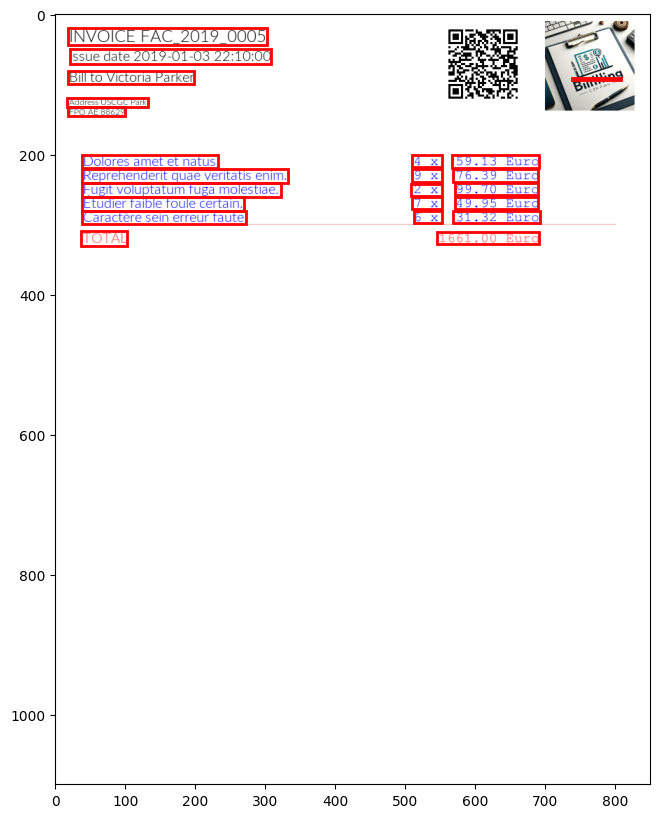

In [98]:
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from io import BytesIO

# Récupération de l'image depuis l'URL
response = requests.get(f"https://invoiceocrp3.azurewebsites.net/invoices/{data[5]['no']}")
image = mpimg.imread(BytesIO(response.content))

# Création d'un nouvel objet `Figure` et d'un nouvel objet `Axes` avec une taille de figure plus grande
fig, ax = plt.subplots(figsize=(10, 10))

# Affichage de l'image
ax.imshow(image)

# Parcours de chaque boîte englobante et dessin d'un rectangle autour du texte
for bbox in resultfacture:
    x1, y1, x2, y2, x3, y3, x4, y4 = bbox
    # Calcul des largeur et hauteur du rectangle
    width = x2 - x1
    height = y3 - y1

    # Création d'un objet Rectangle
    rectangle = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Ajout du rectangle à l'axe
    ax.add_patch(rectangle)


In [12]:
datatest = data[7]

In [13]:
print(datatest)

{'no': 'FAC_2019_0009-2407968', 'dt': '2019-01-04 09:29:00'}


In [15]:
facture = {}
#for row in range(len(data)) :
'''
    OCR: Read File using the Read API, extract text - remote
    This example will extract text in an image, then print results, line by line.
    This API call can also extract handwriting style text (not shown).
'''
    # Get an image with text
read_image_url = f"https://invoiceocrp3.azurewebsites.net/invoices/{datatest['no']}"

    # Call API with URL and raw response (allows you to get the operation location)
read_response = computervision_client.read(read_image_url,  raw=True)

    # Get the operation location (URL with an ID at the end) from the response
read_operation_location = read_response.headers["Operation-Location"]
    # Grab the ID from the URL
operation_id = read_operation_location.split("/")[-1]

count = 0
    # Call the "GET" API and wait for it to retrieve the results 
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
         break
    time.sleep(1)

facture = []
#text[f"text"] = []
#text[f"bounding_box"] = []
#facture[data[row]['no']] = []
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
    # Itérez à travers chaque objet de ligne
        for ligne_objet in text_result.lines:
            # Créez un dictionnaire pour stocker les données de cette ligne
            donnees_ligne = {
                            "text": ligne_objet.text,
                            "bounding_box": ligne_objet.bounding_box,
                            # Ajoutez plus d'attributs selon vos besoins
                        }
            facture.append(donnees_ligne)
    x_min_list = []
    y_min_list = []
    x_max_list = []
    y_max_list = []
    for item in facture:
        text = item['text']
    # Pour simplifier, nous utilisons uniquement les deux premières coordonnées pour afficher le texte
        
        x_min, y_min, x_max, y_max = item['bounding_box'][:4]
        x_min_list.append(item['bounding_box'][1])
        y_min_list.append(item['bounding_box'][2])
        x_max_list.append(item['bounding_box'][3])
        y_max_list.append(item['bounding_box'][4])
        #print(f"{text:<20}     (x_min: {x_min}, y_min: {y_min}, x_max: {x_max}, y_max: {y_max})")
    
    
def sont_sur_la_meme_ligne(elem1, elem2):
    y_coords_elem1 = [elem1['bounding_box'][i] for i in range(1, 8, 2)]
    y_coords_elem2 = [elem2['bounding_box'][i] for i in range(1, 8, 2)]
    seuil = 20 # Ajuster le seuil pour permettre une légère variation
    return all(abs(y1 - y2) < seuil for y1, y2 in zip(y_coords_elem1, y_coords_elem2))

# Organiser les éléments de la facture en lignes
lignes_facture = []
ligne_actuelle = [facture[0]]  # Commence avec le premier élément
for elem in facture[1:]:
    if sont_sur_la_meme_ligne(ligne_actuelle[-1], elem):
        ligne_actuelle.append(elem)
    else:
        lignes_facture.append(ligne_actuelle)
        ligne_actuelle = [elem]



# Ajouter la dernière ligne
lignes_facture.append(ligne_actuelle)
# Afficher les lignes de la facture
for ligne in lignes_facture:
    texte_complet = " ".join(element['text'] for element in ligne)
    #print(texte_complet)

    regexAddress  = r"address.*?(\d+)"
    regexDate     = r"date.*?(\d+)-(\d+)-(\d+).(\d+).(\d+).(\d+)"
    regexName     = r"bill.*?brilllling"
    matchAddresse = re.search(regexAddress, texte_complet)
    matchDate     = re.search(regexDate, texte_complet)
    if matchAddresse:
        resultAddress = matchAddresse.group(0)
        adresse  = re.sub(r'^address\s*', '', resultAddress)
        print("Adresse trouvée :", adresse)
    if matchDate :
        resultDate = matchDate.group(0)
        date   = re.sub(r'^date\s*', '', resultDate)
        print("date trouvée :", date)

"""for i in range(len(ligne)):
        if ligne[i]['text'].startswith('INVOICE'):
            print(ligne)"""

    #print(' '.join(elem['text'] for elem in ligne))

"""text[f"text"].append(ligne_objet.text)
            text[f"bounding_box"].append(ligne_objet.bounding_box)"""
            
                    
                    # Ajoutez les données de cette ligne à la liste corresp ondante dans le dictionnaire principal
                    #if ligne_objet.text.startswith("Issue date"):
        #if donnees_ligne["bounding_box"][-1] in range(300,330):
"""for i in range(len(text['bounding_box']) - 1):
    print(text['text'][i])          
    print(text['bounding_box'][i+1][-1] - text['bounding_box'][i][-1])
                    #facture[data[row]['no']].append(donnees_ligne)"""

"for i in range(len(text['bounding_box']) - 1):\n    print(text['text'][i])          \n    print(text['bounding_box'][i+1][-1] - text['bounding_box'][i][-1])\n                    #facture[data[row]['no']].append(donnees_ligne)"

In [16]:
text = {}
textlist = []
mytext = ''
stringtext =''
count = 0
facture_formatee = ''

for i in range(len(datatest)):
    read_image_url = f"https://invoiceocrp3.azurewebsites.net/invoices/{datatest[i]['no']}"

    # Call API with URL and raw response (allows you to get the operation location)
    read_response = computervision_client.read(read_image_url,  raw=True)

    # Get the operation location (URL with an ID at the end) from the response
    read_operation_location = read_response.headers["Operation-Location"]
    # Grab the ID from the URL
    operation_id = read_operation_location.split("/")[-1]

    count = 0
    # Call the "GET" API and wait for it to retrieve the results 
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    text = {}
    textlist = []
    mytext = ''
    stringtext =''
    count = 0
    facture_formatee = ''
    # Print the detected text, line by line
    if read_result.status == OperationStatusCodes.succeeded:
        
        for text_result in read_result.analyze_result.read_results:
                for line in text_result.lines:
                    count +=1
                    text[f"text {count}"] = line.text
                    

                
    for key in text:
        if text[key].startswith("INVOICE") or text[key].startswith("Issue date") or text[key].startswith("Bill to") or text[key].endswith(".") or text[key].endswith("x") or text[key].endswith("Euro")  or text[key].startswith("TOTAL"):
            stringtext += text[key] + '\n'
    print(stringtext)

KeyError: 0

In [28]:
text = {}
textlist = []
mytext = ''
stringtext =''
count = 0
facture_formatee = ''
# Print the detected text, line by line
if read_result.status == OperationStatusCodes.succeeded:
    
    for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                count +=1
                text[f"text {count}"] = line.text

               
for key in text:
    #if text[key].startswith("INVOICE") or text[key].startswith("Issue date") or text[key].startswith("Bill to") or text[key].endswith(".") or text[key].endswith("x") or text[key].endswith("Euro")  or text[key].startswith("TOTAL"):
        stringtext += text[key] + ' '
print(stringtext)


"""stringtextV2 = stringtext.replace(" ", "\n")


nouvelle_phrase = re.sub(r'Euro', 'Euro\n', stringtext)



# Formater et afficher la facture
facture_formatee = format_facture(stringtext)
factsplit = facture_formatee.split('\n')
print(factsplit)"""


regexAddress  = r"address.*?(\d+)"
regexDate     = r"date.*?(\d+)-(\d+)-(\d+).(\d+).(\d+).(\d+)"
regexName     = r"bill.*?brilllling"
matchAddresse = re.search(regexAddress, stringtext)
matchDate     = re.search(regexDate, stringtext)

if matchAddresse:
    resultAddress = matchAddresse.group(0)
    adresse  = re.sub(r'^address\s*', '', resultAddress)
    print("Adresse trouvée :", adresse)
if matchDate :
      resultDate = matchDate.group(0)
      date   = re.sub(r'^date\s*', '', resultDate)
      print("date trouvée :", date)


INVOICE FAC_2019_0102 Issue date 2019-02-03 02:20:00 Bill to Susanne Da Costa Brilllling Address 175, avenue de Riou 11138 Raymond As dans empire joindre. 9 x 23.26 Euro Plaire intelligence silencieux distance. 5 x 64.18 Euro * * * * * * Provident sunt quod atque. 7 x 33.30 Euro Illo suscipit error dignissimos. 5 x 20.85 Euro Offer expert day war. 3 x 25.83 Euro Career present condition adult. 1 x 93.26 Euro Nobis ipsum odio fugiat. 7 x 34.03 Euro TOTAL 1276.55 Euro 
date trouvée : 2019-02-03 02:20:00


In [39]:
facture = {}
for row in range(len(data)) :
    '''
    OCR: Read File using the Read API, extract text - remote
    This example will extract text in an image, then print results, line by line.
    This API call can also extract handwriting style text (not shown).
    '''
    # Get an image with text
    read_image_url = f"https://invoiceocrp3.azurewebsites.net/invoices/{data[row]['no']}"

    # Call API with URL and raw response (allows you to get the operation location)
    read_response = computervision_client.read(read_image_url,  raw=True)

    # Get the operation location (URL with an ID at the end) from the response
    read_operation_location = read_response.headers["Operation-Location"]
    # Grab the ID from the URL
    operation_id = read_operation_location.split("/")[-1]

    count = 0
    # Call the "GET" API and wait for it to retrieve the results 
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)


    facture[data[row]['no']] = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
    # Itérez à travers chaque objet de ligne
            for ligne_objet in text_result.lines:
            # Créez un dictionnaire pour stocker les données de cette ligne
                    donnees_ligne = {
                        "text": ligne_objet.text,
                        "bounding_box": ligne_objet.bounding_box,
                        # Ajoutez plus d'attributs selon vos besoins
                    }
                    
                    # Ajoutez les données de cette ligne à la liste correspondante dans le dictionnaire principal
                    print(donnees_ligne)
                    facture[data[row]['no']].append(donnees_ligne)
    

            # Maintenant, donnees_lignes contient un dictionnaire avec une seule clé "toutes_les_lignes" qui contient une liste de tous les dictionnaires de données de ligne

{'text': 'INVOICE FAC_2019_0002', 'bounding_box': [17.0, 19.0, 304.0, 19.0, 304.0, 42.0, 17.0, 42.0]}
{'text': 'Issue date 2019-01-01 03:29:00', 'bounding_box': [19.0, 49.0, 308.0, 49.0, 308.0, 70.0, 19.0, 70.0]}
{'text': 'Bill to Sébastien Jean-Vasseur', 'bounding_box': [18.0, 79.0, 276.0, 80.0, 276.0, 99.0, 18.0, 98.0]}
{'text': 'Brilllling', 'bounding_box': [736.0, 95.0, 809.0, 76.0, 812.0, 91.0, 741.0, 112.0]}
{'text': 'Address 19246 Flowers Lake Suite 939', 'bounding_box': [18.0, 119.0, 224.0, 119.0, 224.0, 132.0, 18.0, 131.0]}
{'text': 'New Audreychester, NM 10500', 'bounding_box': [17.0, 133.0, 187.0, 133.0, 187.0, 145.0, 17.0, 146.0]}
{'text': 'Esse reiciendis facere aperiam.', 'bounding_box': [40.0, 200.0, 300.0, 201.0, 300.0, 220.0, 40.0, 219.0]}
{'text': '3 x', 'bounding_box': [511.0, 201.0, 554.0, 203.0, 553.0, 219.0, 511.0, 218.0]}
{'text': ': 56.80 Euro', 'bounding_box': [543.0, 199.0, 690.0, 201.0, 690.0, 219.0, 543.0, 217.0]}
{'text': 'Voluptatum delectus dolore enim.',

KeyboardInterrupt: 

In [40]:
facture

{'FAC_2019_0002-521208': [{'text': 'INVOICE FAC_2019_0002',
   'bounding_box': [17.0, 19.0, 304.0, 19.0, 304.0, 42.0, 17.0, 42.0]},
  {'text': 'Issue date 2019-01-01 03:29:00',
   'bounding_box': [19.0, 49.0, 308.0, 49.0, 308.0, 70.0, 19.0, 70.0]},
  {'text': 'Bill to Sébastien Jean-Vasseur',
   'bounding_box': [18.0, 79.0, 276.0, 80.0, 276.0, 99.0, 18.0, 98.0]},
  {'text': 'Brilllling',
   'bounding_box': [736.0, 95.0, 809.0, 76.0, 812.0, 91.0, 741.0, 112.0]},
  {'text': 'Address 19246 Flowers Lake Suite 939',
   'bounding_box': [18.0, 119.0, 224.0, 119.0, 224.0, 132.0, 18.0, 131.0]},
  {'text': 'New Audreychester, NM 10500',
   'bounding_box': [17.0, 133.0, 187.0, 133.0, 187.0, 145.0, 17.0, 146.0]},
  {'text': 'Esse reiciendis facere aperiam.',
   'bounding_box': [40.0, 200.0, 300.0, 201.0, 300.0, 220.0, 40.0, 219.0]},
  {'text': '3 x',
   'bounding_box': [511.0, 201.0, 554.0, 203.0, 553.0, 219.0, 511.0, 218.0]},
  {'text': ': 56.80 Euro',
   'bounding_box': [543.0, 199.0, 690.0, 201